In [57]:
import sys  
!{sys.executable} -m pip install --user matplotlib
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

data = pd.read_csv("MyEBirdData.csv")

df = pd.DataFrame(data,
                  columns = ['Submission ID', 'Common Name', 'Location', 'State/Province', 'Date', 'Time', 'Count', 'All Obs Reported'] #'Scientific Name', 'Count', 'State/Province', 'County', 'Duration (Min)'
                )
# Reformat & filter on year.
year = 2022
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[(df['Date'].dt.year == year)]
#df = df.loc[(df['Date'].dt.year == 2022) & (df['State/Province'].str.contains("GB"))]
#df = df.loc[(df['Date'].dt.year == 2022) & (df['All Obs Reported'] == 1)]
# Reformat.
#df['County'].fillna('n/a', inplace=True)
df['Count'].replace('X', '1',inplace=True)
df['Count'] = df['Count'].astype(int)


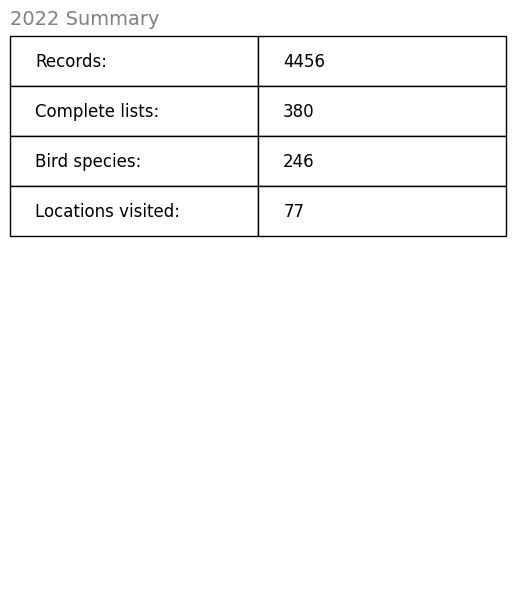

In [58]:
# Total records of all species on all checklists (not counts of number of individuals).
all_records = len(df.index)

# Checklists with number of species recorded.
all_checklists = df.groupby(['Submission ID']).size().count()

# Total species seen
all_species = df.groupby(['Common Name']).size().count()

# Total locations
all_locations = df.groupby(['Location']).size().count()

summary_data = [
    ["Records:", all_records],
    ["Complete lists:", all_checklists],
    ["Bird species:", all_species],
    ["Locations visited:", all_locations]
]

# Hide axes
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')

summary_table = plt.table(cellText=summary_data, loc='top', cellLoc='left')
summary_table.auto_set_font_size(False)
summary_table.set_fontsize(12)
summary_table.scale(1, 3)

plt.title("2022 Summary", x=0.15, y=1.55, fontsize=14, color="grey")
plt.show()



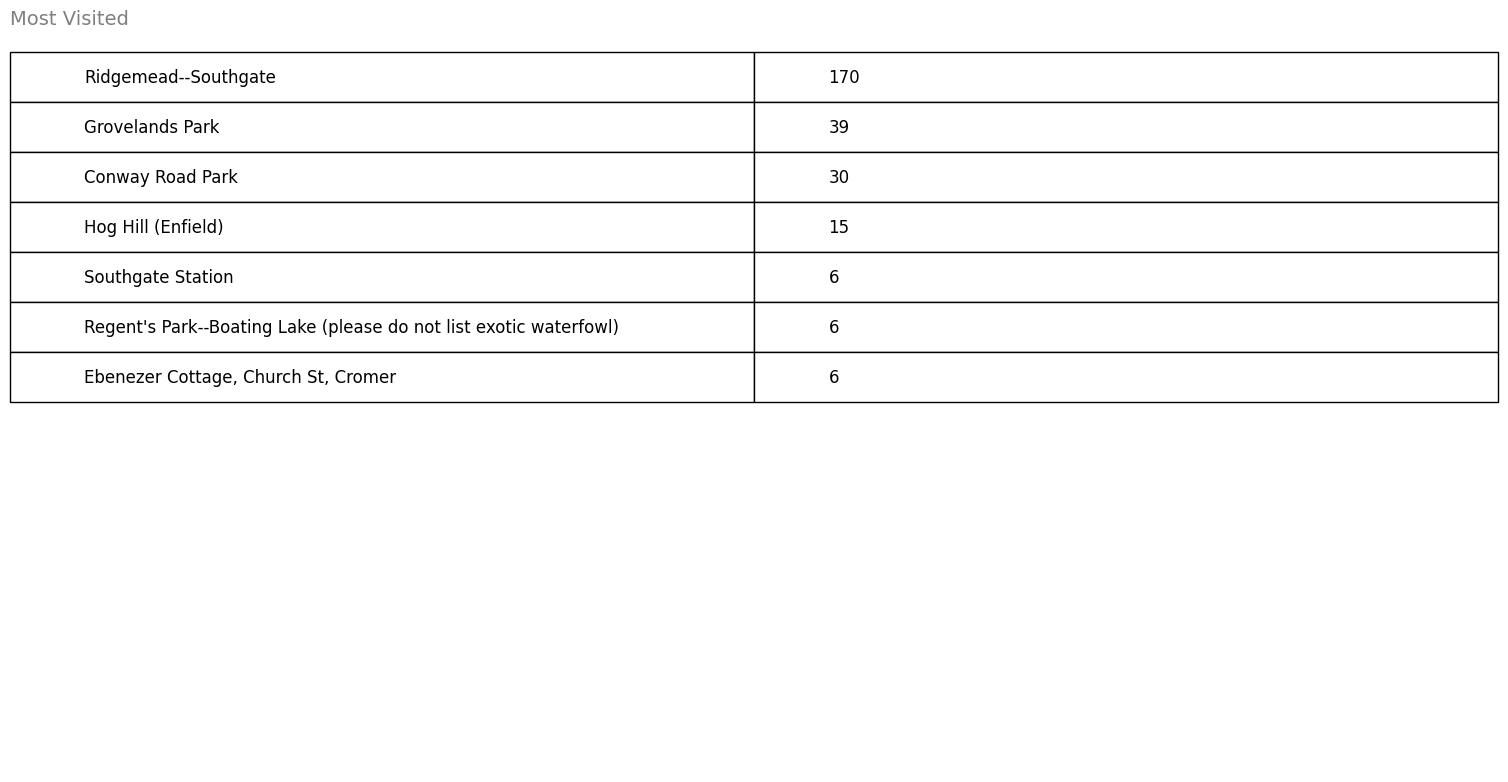

In [59]:
# Most visited locations

toplocs = pd.DataFrame(df, columns=["Location", "Submission ID"]) # Group species records by location for SubmissionID.
toplocs = toplocs.groupby(["Submission ID"]).first() # Take first reord at location for SubmissionID
toplocs_counts = toplocs.value_counts().sort_values(ascending=False).head(7) # Count & sort occurrence of individual locations.
toplocs_counts = toplocs_counts.reset_index() # Make location name index to a column.
#print(toplocs_counts)

# Hide axes
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')

toplocs_table = plt.table(cellText=toplocs_counts.values, loc='top', cellLoc='left')
toplocs_table.auto_set_font_size(False)
toplocs_table.set_fontsize(12)
toplocs_table.scale(3, 3)

plt.title("Most Visited", x=-0.88, y=2.0, fontsize=14, color="grey")
plt.show()


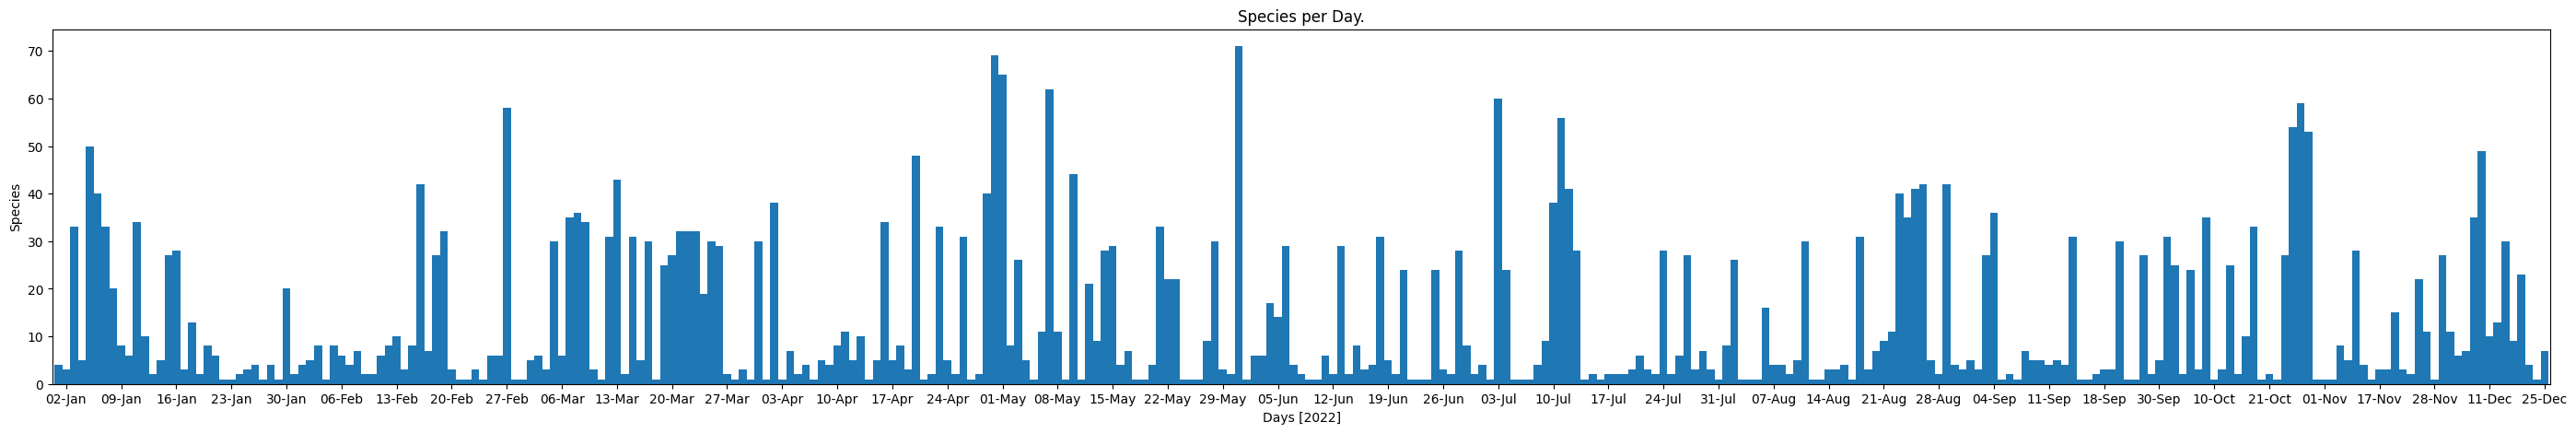

In [60]:
# Species each day
species_days = df.groupby(['Common Name', 'Date']).first('365D') # First record of Common Name for each day.
species_days = species_days.index.to_frame(index=False) # Index contains 'Common Name' & 'Date', so make it a frame.

species_daily = species_days.groupby(['Date']).size() # Monthly number of species.
species_daily = species_daily.rename_axis('Days').reset_index(name='Species') # Important!
species_daily['Days'] = species_daily['Days'].dt.strftime('%d-%b')

import matplotlib.dates as mdates
from matplotlib.dates import DayLocator

species_d_plot = species_daily.plot.bar(x='Days', title='Species per Day.', figsize=(35, 5), width=1.0, rot=0)

species_d_plot.xaxis.set_major_locator(DayLocator(interval=7))
#species_plot.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y')) # x-axis will stop at Nov! If only it worked->days of toil!

species_d_plot.set_xlabel('Days ['+ str(year) + ']')
species_d_plot.set_ylabel('Species')

species_d_plot.get_legend().remove()
plt.show()

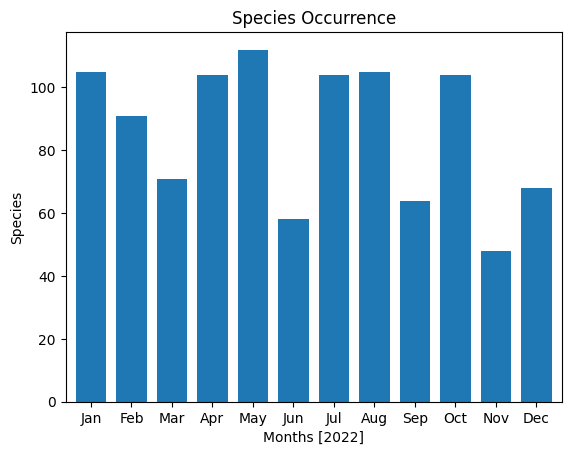

In [68]:
# Species by month.
from datetime import datetime

species = df.groupby(['Common Name', df['Date'].dt.month]).first('12M') # First record of Common Name for each month.

species_months = species.index.to_frame(index=False) # Index contains 'Common Name', 'Date' as Month, so make it a frame.
species_months['Count'] = species['Count'].reset_index(drop=True) # Add column of Count for Abundance.
#species_months.rename(columns={'Date': 'Month'}, inplace=True)

spp_occ = species_months.groupby(['Date']).size().to_frame('Occ.') # Monthly number of species.
spp_occ = spp_occ.rename_axis('Date').reset_index() # Move index to column.

# Convert month number to date then format as short month name.
#spp_occ['Date'] = [datetime.strptime(s, '%m') for s in spp_occ['Date'].astype('str')]
spp_occ['Date'] = pd.to_datetime(spp_occ['Date'].astype('str'), format='%m')
spp_occ['Date'] = spp_occ['Date'].dt.strftime('%b')

spp_occ_plt = spp_occ.plot.bar(x='Date', title='Species Occurrence', width=0.75, rot=0)
spp_occ_plt.set_xlabel('Months ['+ str(year) + ']')
spp_occ_plt.set_ylabel('Species')
spp_occ_plt.get_legend().remove()

plt.show()

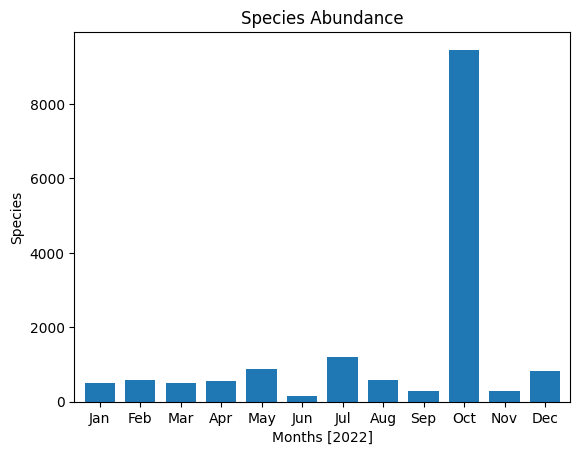

In [69]:


from datetime import datetime


spp_abu = species_months.groupby(['Date']).sum() # Monthly count of individuals.
spp_abu = spp_abu['Count'].copy().to_frame('Abu.') # Remove 'Common Name' column.

spp_abu = spp_abu.rename_axis('Date').reset_index()

# Convert month number to date then format as short month name.
#spp_abu['Date'] = [datetime.strptime(s, '%m') for s in spp_abu['Date'].astype('str')]
spp_abu['Date'] = pd.to_datetime(spp_abu['Date'].astype('str'), format='%m')
spp_abu['Date'] = spp_abu['Date'].dt.strftime('%b')

spp_abu_plt = spp_abu.plot.bar(x='Date', title='Species Abundance', width=0.75, rot=0)
spp_abu_plt.set_xlabel('Months ['+ str(year) + ']')
spp_abu_plt.set_ylabel('Species')
spp_abu_plt.get_legend().remove()

plt.show()

In [72]:
# Species and occurrence on checklists
#lp['Common Name'].value_counts() <- this also works for Abun.

freq = "Frequency.[%s]" % all_checklists
occu = "Occurrence.[Freq./%s]" % all_checklists
abun = "Abundance"

x = df.groupby(['Common Name']).size().to_frame(freq)

x[occu] = x[freq] / all_checklists
x = x.round({occu: 3})

x[abun] = df.groupby('Common Name')['Count'].sum()

x = x.sort_values(by=[abun, occu], ascending=False).head(50)
x = x.reset_index()
display(x)


,Common Name,Frequency.[380],Occurrence.[Freq./380],Abundance
0,Red Knot,1,0.003,8000
1,Northern Gannet,5,0.013,4103
2,Common Guillemot,4,0.011,2101
3,Razorbill,4,0.011,2101
4,Black-headed Gull,84,0.221,1924
5,Common Starling,93,0.245,1652
6,Black-legged Kittiwake,3,0.008,1600
7,Eurasian Coot,68,0.179,1578
8,Canada Goose,71,0.187,1432
9,Common Woodpigeon,178,0.468,1232


In [64]:
#%matplotlib inline
'''
xc = pd.DataFrame(lp, columns = ['Date', 'Count'])

xc = xc.groupby('Date').sum()

xc.plot(kind='bar', title='Species abundance by checklist.')

xc
'''

"\nxc = pd.DataFrame(lp, columns = ['Date', 'Count'])\n\nxc = xc.groupby('Date').sum()\n\nxc.plot(kind='bar', title='Species abundance by checklist.')\n\nxc\n"